## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

## Simulation 

In [2]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

In [3]:
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

In [4]:
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 500)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

In [5]:
# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
print(Phi.shape)
print(scaled_Phi.shape)

(127, 127, 500)
(127, 127, 500)


..................

<ipython-input-6-52f9521722ac>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
MovieWriter ffmpeg unavailable; using Pillow instead.


..................

ValueError: unknown file extension: .mp4

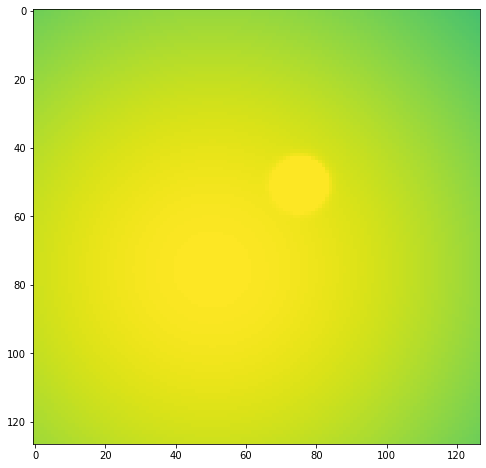

In [6]:
import matplotlib.animation as animation

fps = 30
nSeconds = 500/fps
# snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

a=Phi
snapshots = Phi
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[:,:,0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[:,:,i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )
writergif = animation.PillowWriter(fps=30)
anim.save('Toy_1_Phi.gif', writer=writergif)#, fps=30)


print('Done!')

# plt.show()  # Not required, it seems!

## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [4]:
# init model & load data
data_path = '../data/npy/toy1.npy'
model_path = '../model/toy1/'
result_path = '../result/toy1/'

# np.save(data_path, Phi.T)

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [5]:
# training
Training = False
if Training:
    archs = [[1,2,3,4],[1,2,3,4],[1,3,5,7]]
    tols = [0.001, 0.0005, 0.0001]
    net.train_net(archs=archs, dataset=dataset, max_epoch=500, batch_size=350, 
                  tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
                  result_path=result_path, std=0.01, verbose=2)

## Results

In [6]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_1
model_L0_2
model_L0_3
model_L1_0
model_L1_1
model_L1_2
model_L1_3
model_L2_0
model_L2_1
model_L2_2
model_L2_3


In [7]:
print(models)

{'model_L0_0': CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
), 'model_L0_1': CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_Conv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
), 'model_L0_2': CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )

500
data shape =  (500, 127, 127)


C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\MrCAE\src\utils.py:137: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  for c in mask.nonzero():


a shape =  torch.Size([500, 1, 127, 127])
..................Done!


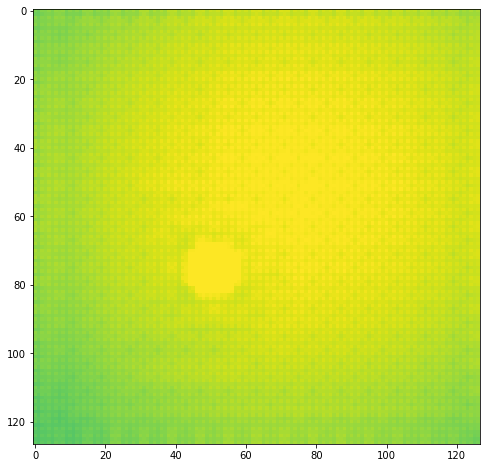

In [6]:
import matplotlib.animation as animation

model = models['model_L2_3']

data = np.load(data_path)
fps = 30
nSeconds = len(data) / fps
print(len(data))
# snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

# a=Phi
# for i in range(n_samples):
i = 0
n_step= 1
# _, _, data = dataset.obtain_data_at_current_level(level=0)
# data,_, _ = dataset.obtain_data_at_current_level(level=2)
print("data shape = ", data.shape)
# data_to_model = data[0].unsqueeze(0)
# print("data_to_model shape = ", data_to_model.shape)
data = torch.tensor(data).unsqueeze(1).float()
a, _, _, _ = model(data, model.cur_level)
print("a shape = ", a.shape)
#     axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    
# snapshots = model(Phi, torch.tensor(0))
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

# a = snapshots[:,:,0]
im = plt.imshow(a.detach().numpy()[0][0], interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )
#     a, _, _, _ = model([data[[i*n_step], :, :, :]], model.cur_level)
    im.set_array(a.detach().numpy()[i][0] )
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )
writergif = animation.PillowWriter(fps=30)
anim.save('Toy_1_Phi_predicted_level2.gif', writer=writergif)#, fps=30)


print('Done!')


self.n_levels =  3
level =  0
self.n_levels - level - 1 = 2
train_data shape =  torch.Size([500, 1, 127, 127])
i =  0
train_data shape =  torch.Size([500, 1, 63, 63])
i =  1
train_data shape =  torch.Size([500, 1, 31, 31])
data shape =  torch.Size([500, 1, 31, 31])
model.cur_level =  0
a shape =  torch.Size([500, 1, 31, 31])
..................Done!


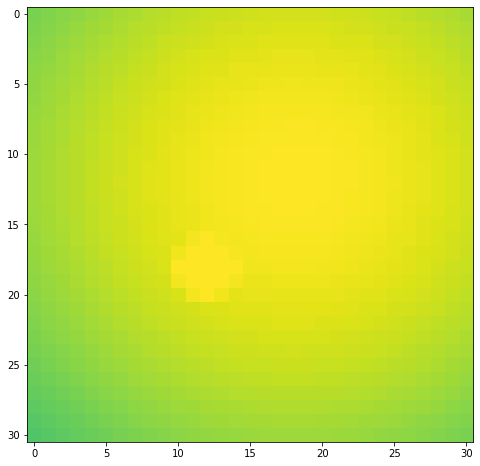

In [10]:
import matplotlib.animation as animation

dataset_graph = net.MultiScaleDynamicsDataSet(data_path, n_levels=3, train_ratio=1.0,  valid_ratio=0.0, shuffle = False)
model = models['model_L0_0']

# data = np.load(data_path)
fps = 30
# nSeconds = len(data) / fps

# data = torch.tensor(data).unsqueeze(1).float()
data,_,_ = dataset_graph.obtain_data_at_current_level(level=0)
fps = 30
nSeconds = len(data) / fps
print("data shape = ", data.shape)
print("model.cur_level = ", model.cur_level)
a, _, _, _ = model(data[:,:,:,:], model.cur_level)
a = data
print("a shape = ", a.shape)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

# a = snapshots[:,:,0]
im = plt.imshow(a.detach().numpy()[0][0] , interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )
    im.set_array(a.detach().numpy()[i][0] )
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )
writergif = animation.PillowWriter(fps=30)
anim.save('Toy_1_Phi_predicted_level0.gif', writer=writergif)#, fps=30)


print('Done!')


dict_keys(['0', '1', '2', '3'])
dict_keys(['0', '1', '2', '3'])
dict_keys(['0', '1', '2', '3'])


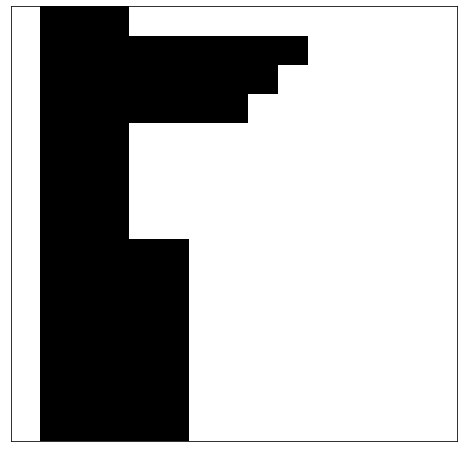

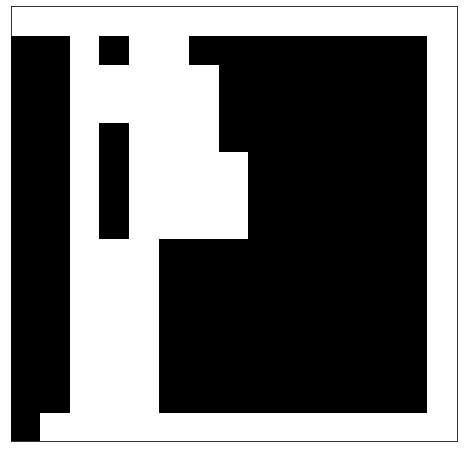

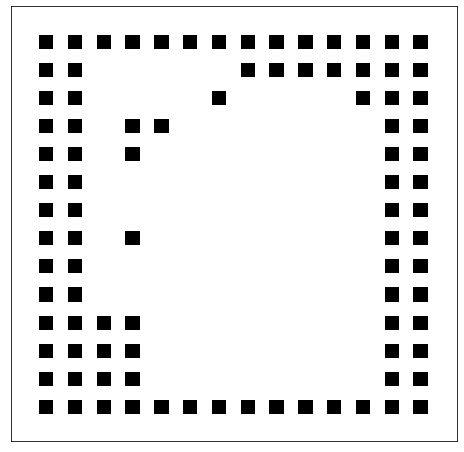

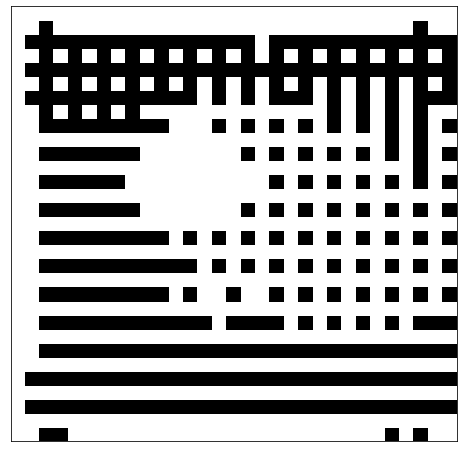

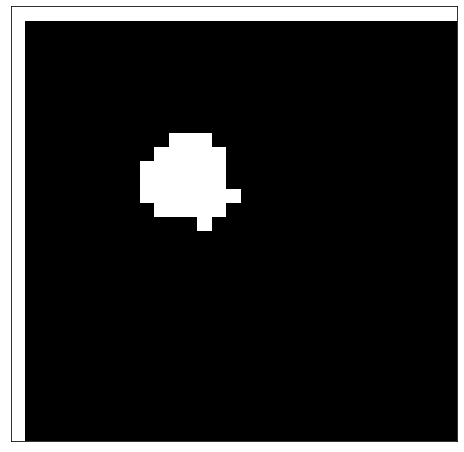

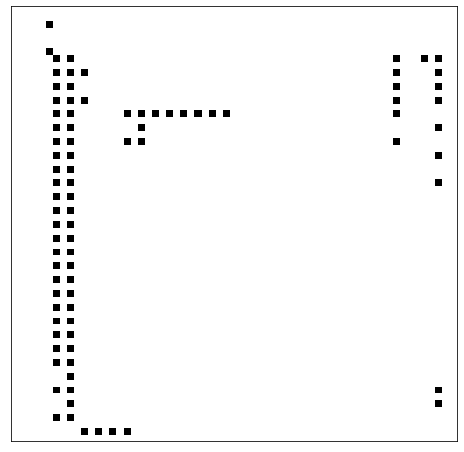

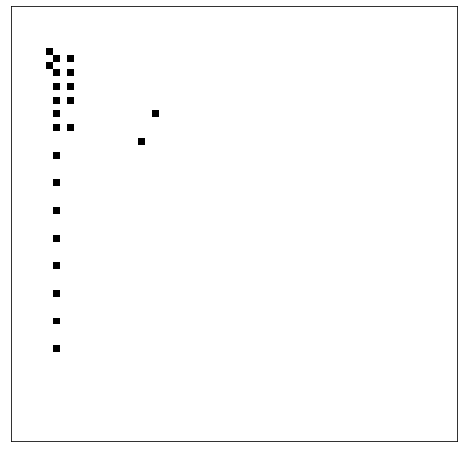

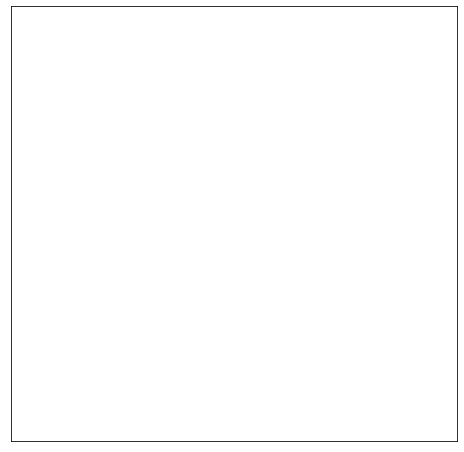

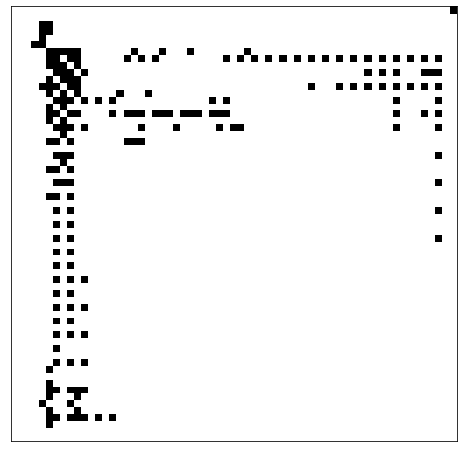

In [8]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

self.n_levels =  3
level =  0
self.n_levels - level - 1  2
train_data shape =  torch.Size([350, 1, 127, 127])
i =  0
train_data shape =  torch.Size([350, 1, 63, 63])
i =  1
train_data shape =  torch.Size([350, 1, 31, 31])
data[[i*n_step], :, :, :].shape =  torch.Size([1, 1, 31, 31])
0


C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\MrCAE\src\utils.py:144: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  for c in mask.nonzero():


torch.Size([1, 1, 31, 31])
self.n_levels =  3
level =  0
self.n_levels - level - 1  2
train_data shape =  torch.Size([350, 1, 127, 127])
i =  0
train_data shape =  torch.Size([350, 1, 63, 63])
i =  1
train_data shape =  torch.Size([350, 1, 31, 31])
data[[i*n_step], :, :, :].shape =  torch.Size([1, 1, 31, 31])
0
torch.Size([1, 1, 31, 31])
self.n_levels =  3
level =  0
self.n_levels - level - 1  2
train_data shape =  torch.Size([350, 1, 127, 127])
i =  0
train_data shape =  torch.Size([350, 1, 63, 63])
i =  1
train_data shape =  torch.Size([350, 1, 31, 31])
data[[i*n_step], :, :, :].shape =  torch.Size([1, 1, 31, 31])
0
torch.Size([1, 1, 31, 31])
self.n_levels =  3
level =  0
self.n_levels - level - 1  2
train_data shape =  torch.Size([350, 1, 127, 127])
i =  0
train_data shape =  torch.Size([350, 1, 63, 63])
i =  1
train_data shape =  torch.Size([350, 1, 31, 31])
data[[i*n_step], :, :, :].shape =  torch.Size([1, 1, 31, 31])
0
torch.Size([1, 1, 31, 31])
self.n_levels =  3
level =  0
self

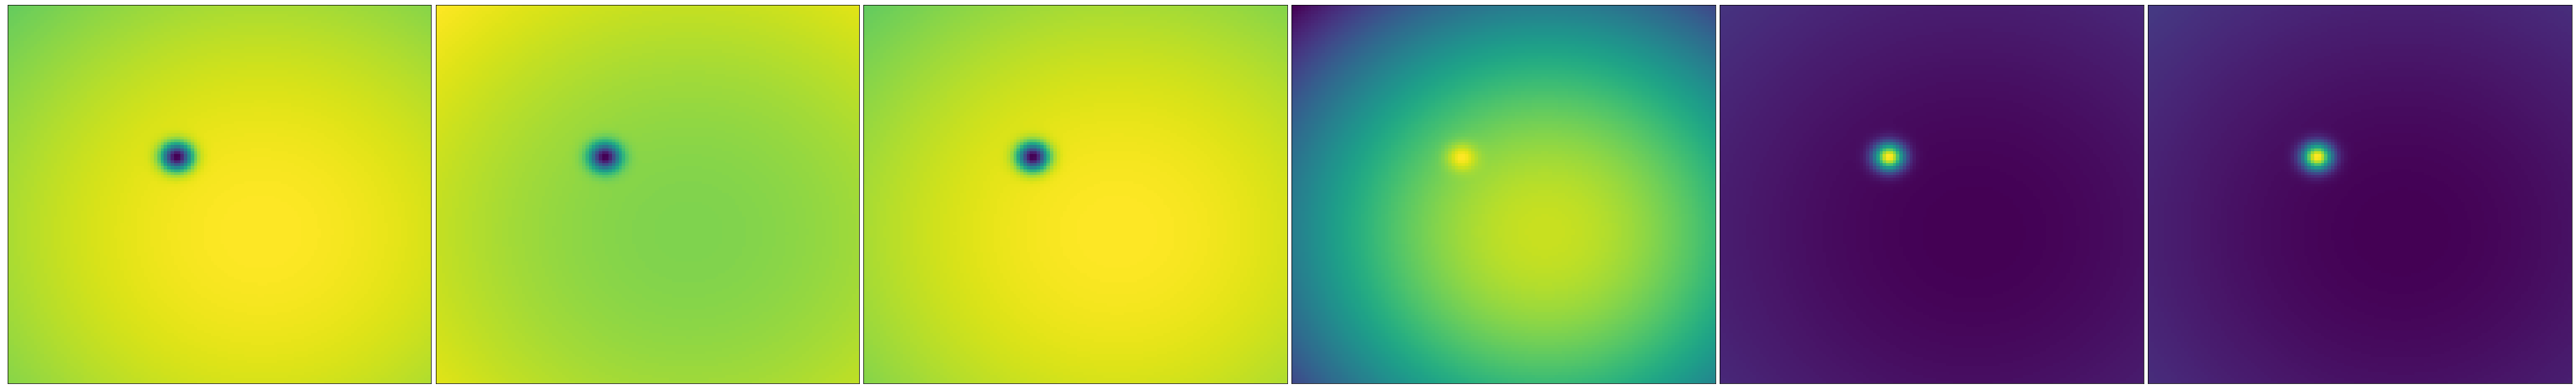

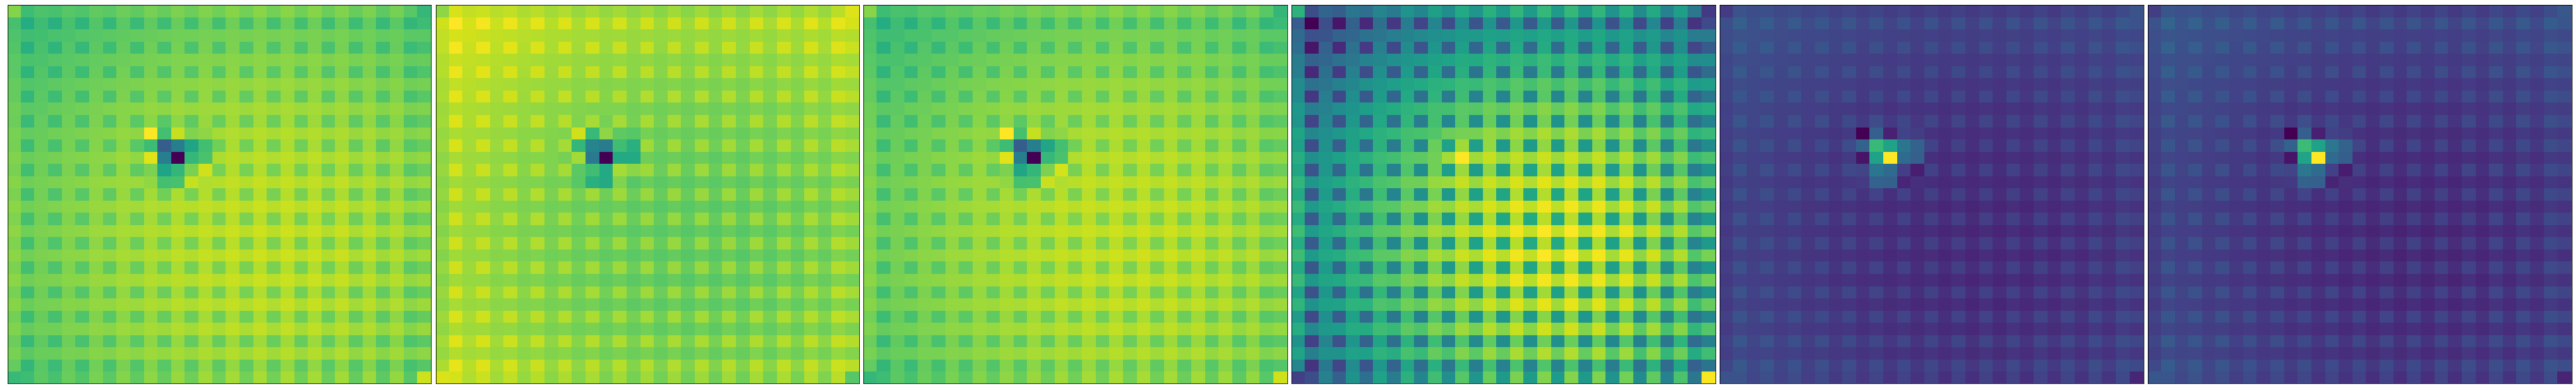

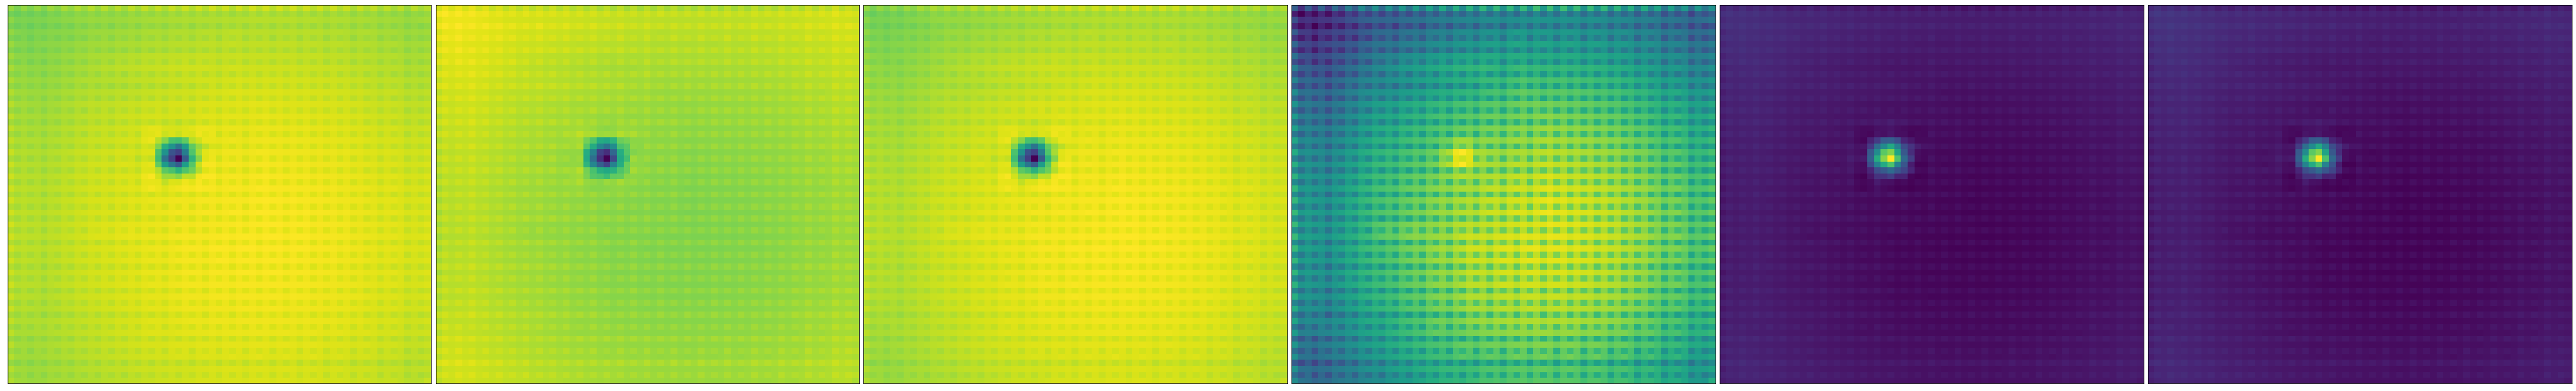

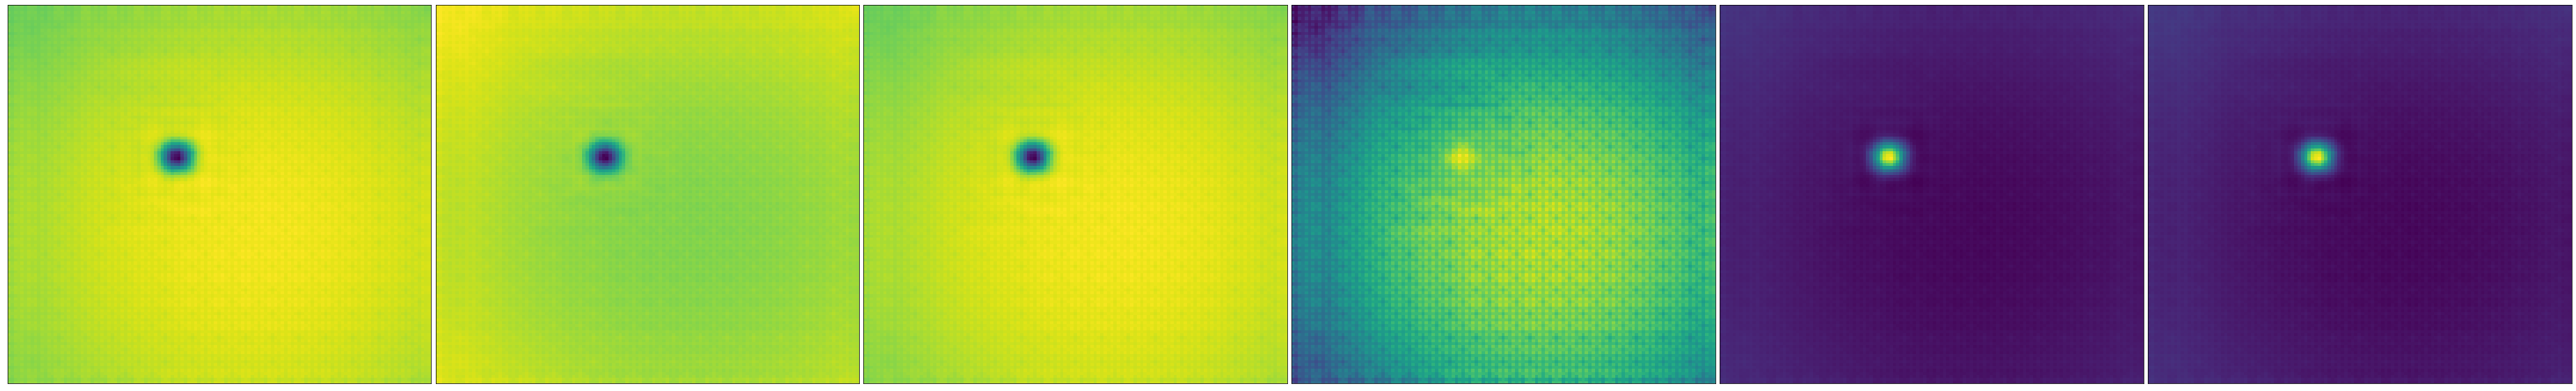

In [5]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
# print(len(dataset))
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    print("data[[i*n_step], :, :, :].shape = ", data[[i*n_step], :, :, :].shape)
    print(model.cur_level)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    print(output.shape)
#     ghj
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    print("data[[i*n_step], :, :, :].shape = ", data[[i*n_step], :, :, :].shape)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    print("data[[i*n_step], :, :, :].shape = ", data[[i*n_step], :, :, :].shape)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[inds[::n_step]], np.cos(w0*t[inds[::n_step]]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[inds[::n_step]], np.cos(w1*t[inds[::n_step]] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [ ]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

In [ ]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))